In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
data.loc[data['quality']>5,'boolQuality'] = 1

In [4]:
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix
     

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets 
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)

In [15]:
class ANNwine_withBNorm(nn.Module):
    def __init__(self):
        super().__init__()
        # Input layer
        self.input = nn.Linear(11, 16)
        self.bnorm_input = nn.BatchNorm1d(16)
        
        # Hidden layers
        self.fc1 = nn.Linear(16, 32)
        self.bnorm1 = nn.BatchNorm1d(32)
        
        self.fc2 = nn.Linear(32, 20) 
        self.bnorm2 = nn.BatchNorm1d(20)
        
       
        self.output = nn.Linear(20, 1)

    def forward(self, x, doBN=True):
        
        # Input layer
        x = self.input(x)
        if doBN: x = self.bnorm_input(x)
        x = F.relu(x)

        # Hidden layer 1
        x = self.fc1(x)
        if doBN: x = self.bnorm1(x)
        x = F.relu(x)

        # Hidden layer 2
        x = self.fc2(x)
        if doBN: x = self.bnorm2(x)
        x = F.relu(x)

        # Output layer (no activation for regression)
        return self.output(x)

In [12]:
# global parameter
numepochs = 1000

def trainTheModel(doBN=True):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X,doBN)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)



    ### test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X,doBN)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [16]:
# create and train a model NO BATCHNORM
winenet = ANNwine_withBNorm()
trainAccNo,testAccNo,lossesNo = trainTheModel(False)

# create and train a model WITH BATCHNORM
winenet = ANNwine_withBNorm()
trainAccWith,testAccWith,lossesWith = trainTheModel(True)

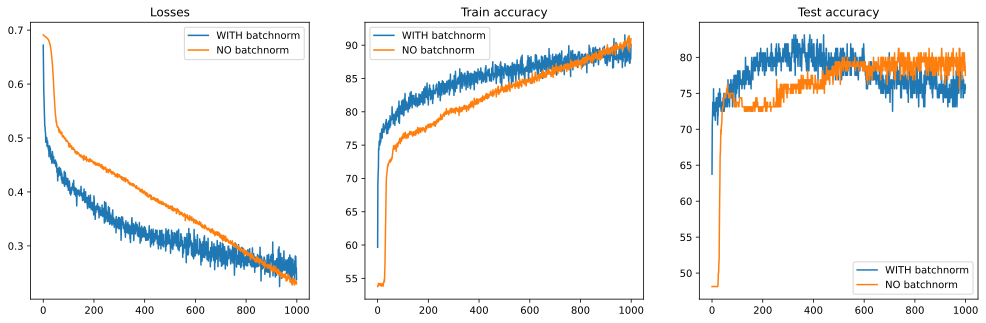

In [17]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(lossesWith,label='WITH batchnorm')
ax[0].plot(lossesNo,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAccWith,label='WITH batchnorm')
ax[1].plot(trainAccNo,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAccWith,label='WITH batchnorm')
ax[2].plot(testAccNo,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()